<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
'''
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!pip install ./deepul
!pip install scikit-learn
'''

'\n!if [ -d deepul ]; then rm -Rf deepul; fi\n!git clone https://github.com/rll/deepul.git\n!pip install ./deepul\n!pip install scikit-learn\n'

In [4]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

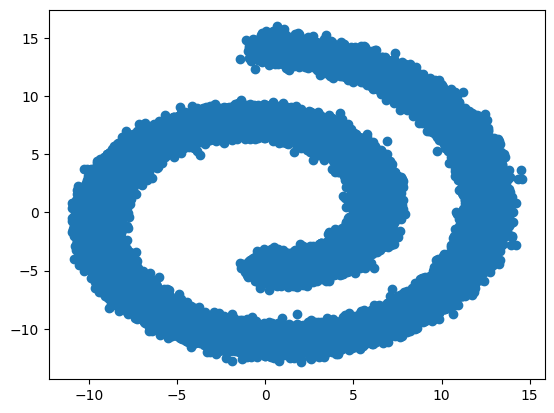

In [3]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )

    def forward(self,x,t):
        x = torch.cat([x,t],dim=1)
        return self.net(x)

def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """
    
    # 1. 计算训练数据的均值和标准差
    train_mean = np.mean(train_data, axis=0)
    train_std = np.std(train_data, axis=0)

    # 2. 标准化训练数据和测试数据
    train_data = (train_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std  
    

    train_data = torch.tensor(train_data)
    test_data = torch.tensor(test_data)


    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-3 )
    loss_fn = nn.MSELoss()

    num_epochs = 100
    batch_size = 1024
    num_steps = np.power(2, np.linspace(0, 9, 9)).astype(int)

    train_losses = []
    test_losses = []
    all_samples = np.zeros((9,2000,2))

    epoch_train_loss = 0
    num_batches = 0


    for epoch in range(num_epochs):
        model.train()
        for i in range(0,len(train_data),batch_size):
            batch = train_data[i:i+batch_size] #(batchsize,2)
            t = torch.rand(batch.shape[0]) #(batchsize,)
            noise = torch.randn_like(batch)  #(batchsize,2)

            noisy_data = torch.cos(0.5*np.pi*t.unsqueeze(1))*batch+torch.sin(0.5*np.pi*t.unsqueeze(1))*noise
            t=t.unsqueeze(1)

            predicted_noise = model(noisy_data,t)

#            print(predicted_noise[:10])
            loss = loss_fn(predicted_noise,noise)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss += loss.item()  # 累加每个 mini-batch 的损失
            num_batches += 1

        
        train_losses.append(epoch_train_loss / num_batches)  

        epoch_train_loss = 0
        num_batches = 0


        for param in model.parameters():
            param.requires_grad = False


        t = torch.rand(test_data.shape[0]).unsqueeze(1)
        noise = torch.randn_like(test_data)
        noisy_data = torch.cos(0.5*np.pi * t) * test_data + torch.sin(0.5*np.pi * t) * noise
        predicted_noise = model(noisy_data, t)
        test_loss = loss_fn(predicted_noise, noise).item()
        test_losses.append(test_loss)


        for param in model.parameters():
            param.requires_grad = True
        


    for idx, steps in enumerate(num_steps):
        x = torch.randn(2000, 2)  
        t_array = np.linspace(1 - 1e-4, 1e-4, steps+1)
        for i in range(steps):

            t_tensor = torch.tensor(t_array[i],dtype=torch.float32).repeat(2000).unsqueeze(1)
            t_pre_tensor = torch.tensor(t_array[i+1],dtype=torch.float32).repeat(2000).unsqueeze(1)
            predicted_noise = model(x, t_tensor)  

            alphat = torch.cos(0.5*np.pi * t_tensor)
            sigmat = torch.sin(0.5*np.pi * t_tensor)
            alphat_1 = torch.cos(0.5*np.pi * (t_pre_tensor))
            sigmat_1 = torch.sin(0.5*np.pi * (t_pre_tensor))
            epsilon = torch.randn_like(x)

            eta = sigmat_1/sigmat*torch.sqrt(1-alphat**2/alphat_1**2)
            clamped_value = torch.clamp(sigmat_1**2-eta**2, min=0)
            x = alphat_1*(x-sigmat*predicted_noise)/alphat+torch.sqrt(clamped_value)*predicted_noise + eta*epsilon



        x = x * torch.tensor(train_std) + torch.tensor(train_mean) 
        
        all_samples[idx] = x.detach().numpy()  

    return np.array(train_losses), np.array(test_losses), all_samples



    return train_losses, test_losses, all_samples

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
torch.Size([2000, 2])
tensor([[5.9605e-08],
        [5.9605e-08],
        [5.9605e-08],
        ...,
        [5.9605e-08],
        [5.9605e-08],
        [5.9605e-08]])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
torch.Size([2000, 2])
tensor([[1.7881e-07],
        [1.7881e-07],
        [1.7881e-07],
        ...,
        [1.7881e-07],
        [1.7881e-07],
        [1.7881e-07]])
tensor([[0.0858],
        [0.0858],
        [0.0858],
        ...,
        [0.0858],
        [0.0858],
        [0.0858]])
tensor([[0.0251],
        [0.0251],
        [0.0251],
        ...,
        [0.0251],
        [0.0251],
        [0.0251]])
tensor([[-3.5527e-15],
        [-3.5527e-15],
        [-3.5527e-15],
        ...,
        [-3.5527e-15],
        [-3.5527e-15],
        [-3.5527e-15]])
torch.Size([2000, 2])
tensor([[1.0729e-06],
        [1.0729e-06],
      

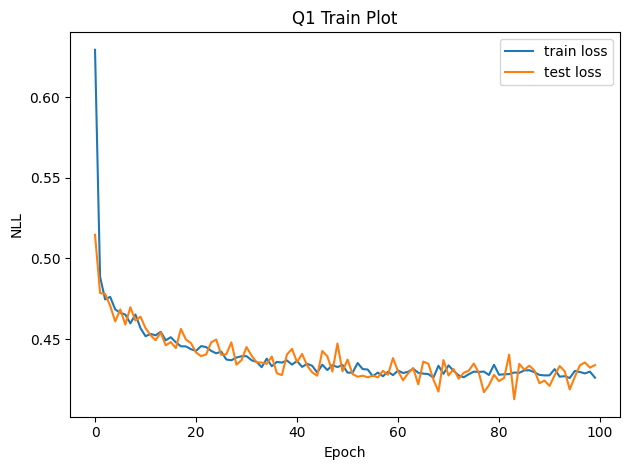

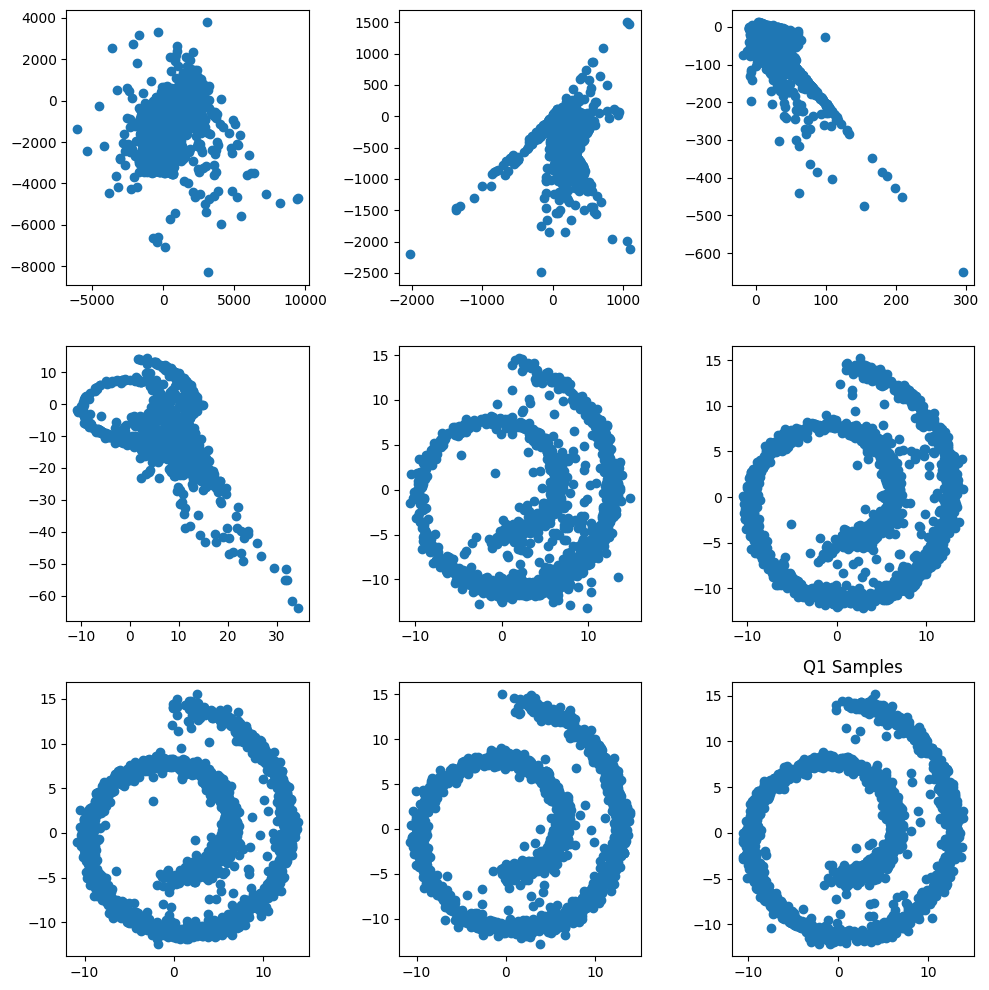

In [5]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


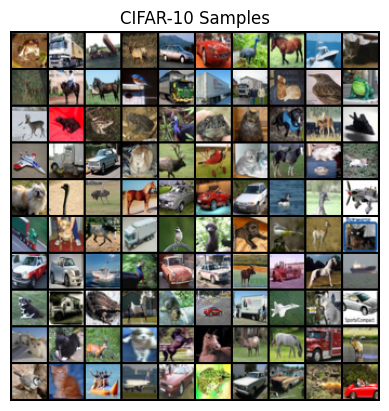

In [6]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, TensorDataset
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def timestep_embedding(timesteps, dim, max_period=10000):

    half = dim // 2
    timesteps = timesteps.squeeze().to(device)
    freqs = torch.exp(-torch.log(torch.tensor(max_period, dtype=torch.float32)) * torch.arange(0, half, dtype=torch.float32) / half).to(device)
    args = torch.tensor(timesteps,dtype = torch.float32)[:, None] * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:  #if dim is odd
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super(ResidualBlock,self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.temb_channels = temb_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.conv3 = nn.Conv2d(in_channels,out_channels,1)
        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)

        self.Linear = nn.Sequential(
            nn.Linear(temb_channels,out_channels),
            nn.SiLU(),
            nn.Linear(out_channels,out_channels)           
        )

    def forward(self,x,temb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h)
        temb = self.Linear(temb)
        #print(temb.shape)
        
        
        h = h+temb[:,:,None,None]


        h = self.norm2(h)
        h = F.silu(h)

        if self.in_channels != self.out_channels:
            x = self.conv3(x)
        
        return x+h

class Downsample(nn.Module):
    def __init__(self,in_channels):
        super(Downsample,self).__init__()
        self.conv = nn.Conv2d(in_channels,in_channels,3,stride = 2,padding = 1)

    def forward(self,x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self,in_channels):
        super(Upsample,self).__init__()
        self.conv = nn.Conv2d(in_channels,in_channels,3,padding = 1)
    
    def forward(self,x):
        x = F.interpolate(x,scale_factor=2)
        return self.conv(x)

class Unet(nn.Module):
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super(Unet, self).__init__()
        self.hidden_dims = hidden_dims
        self.blocks_per_dim = blocks_per_dim
        
        temb_channels = hidden_dims[0] * 4
        self.temb_net = nn.Sequential(
            nn.Linear(hidden_dims[0], temb_channels),
            nn.SiLU(),
            nn.Linear(temb_channels, temb_channels)
        )

        self.init_conv = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)
        self.down_blocks = nn.ModuleList()

        self.appended_block = ResidualBlock(hidden_dims[-1],hidden_dims[-1],temb_channels)
        self.mid_res_block1 = ResidualBlock(hidden_dims[-1],hidden_dims[-1],temb_channels)
        self.mid_res_block2 = ResidualBlock(hidden_dims[-1],hidden_dims[-1],temb_channels)
        prev_ch = hidden_dims[0]

        down_block_chans = [prev_ch]
        for i, hidden_dim in enumerate(hidden_dims):
            for _ in range(blocks_per_dim):
                self.down_blocks.append(ResidualBlock(prev_ch, hidden_dim, temb_channels))
                down_block_chans.append(hidden_dim)
                prev_ch = hidden_dim
            
            if i != len(hidden_dims) - 1:
                self.down_blocks.append(Downsample(prev_ch))
                down_block_chans.append(prev_ch)                


        self.up_blocks = nn.ModuleList()
        for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
            for j in range(blocks_per_dim + 1):
                dch = down_block_chans.pop()
                self.up_blocks.append(ResidualBlock(prev_ch + dch, hidden_dim, temb_channels))
                prev_ch = hidden_dim
                if i and j == blocks_per_dim:
                    self.up_blocks.append(Upsample(prev_ch))
        

        self.gnorm = nn.GroupNorm(num_groups=8, num_channels=prev_ch)       
        self.final_conv = nn.Conv2d(prev_ch, in_channels, 3, padding=1)

    def forward(self, x, t):
        # 确保输入 x 和 t 都是 float32
        x = x.float()
        t = t.float() #(bat,1,1,1)


        #temb_channels = self.hidden_dims[0] * 4
        emb = timestep_embedding(t, self.hidden_dims[0]).float()  # 确保时间步嵌入为 float32
        emb = self.temb_net(emb)

        h = self.init_conv(x).float()  # 确保 h 是 float32 类型
        hs = [h]
        prev_ch = self.hidden_dims[0]
        down_block_chans = [prev_ch]

        for i in range(len(self.down_blocks)):
            block = self.down_blocks[i]
            if i%3 == 2:
                h = block(h)
                hs.append(h)
            
            else:
                h = block(h,emb)
                hs.append(h)

        h = self.mid_res_block1(h, emb).float()
        h = self.mid_res_block2(h, emb).float()

        for i in range(len(self.up_blocks)):
            block = self.up_blocks[i]
            if i%4 ==3:
                h = block(h)
            
            else:
                htemp = hs.pop()
                h = block(torch.cat((h,htemp),dim=1),emb)


        h = self.gnorm(h)
        h = F.silu(h)
        out = self.final_conv(h)

        return out








**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

Files already downloaded and verified
Files already downloaded and verified
Final Test Loss: 0.0648


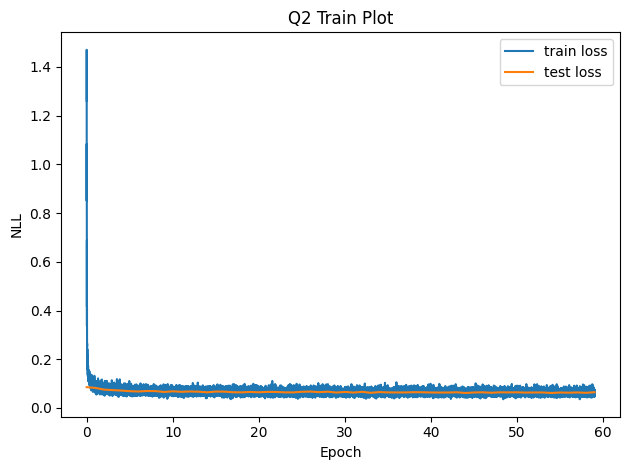

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


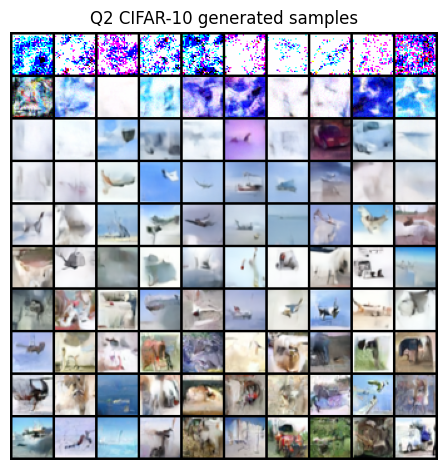

In [2]:
def q2(train_data, test_data):
    
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """

    #model training code
    '''

    
    
    #data_processing
    hidden_dims = [64,128,256,512]
    blocks_per_dim = 2
    in_channels = 3
    train_data = train_data*2-1
    test_data = test_data*2-1

    train_data = torch.tensor(train_data.transpose((0, 3, 1, 2)))
    test_data = torch.tensor(test_data.transpose((0, 3, 1, 2)))

    model = Unet(in_channels,hidden_dims,blocks_per_dim).to(device)
    optimizer = optim.Adam(model.parameters(),lr = 1e-3)
    loss_fn = nn.MSELoss()
    num_steps = np.power(2, np.linspace(0, 9, 10)).astype(int)

    train_dataset = TensorDataset(train_data)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

    test_dataset = TensorDataset(test_data)
    # 创建 DataLoader 实例，设置批量大小为 256（例如）
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)    


    train_losses = []
    test_losses = []
    all_samples = np.zeros((9,2000,2))

    num_epochs = 60

    for epoch in range(num_epochs):
        print("epoch:",epoch)
        model.train()


        for batch in train_loader:
            batch = batch[0].to(device)  # 获取当前批次数据并转移到设备
            t = torch.rand(batch.shape[0], device=device).view(-1, 1, 1, 1).float()  # (batchsize, 1, 1, 1)
            noise = torch.randn_like(batch).float().to(device)

            noisy_data = torch.cos(0.5 * np.pi * t) * batch + torch.sin(0.5 * np.pi * t) * noise
            noisy_data = noisy_data.float()
            
            optimizer.zero_grad()
            predicted_noise = model(noisy_data, t)

            loss = loss_fn(predicted_noise, noise)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

    

        # 将模型设置为评估模式
        model.eval()

        # 用于存储总损失的变量
        total_test_loss = 0

        # 迭代测试数据的小批量
        with torch.no_grad():
            for batch in test_loader:
                # 将每个小批量移动到设备（GPU）
                batch = batch[0].to(device)  # 假设 batch[0] 是图像数据

                # 生成 t 和 noise
                t = torch.rand(batch.shape[0]).to(device)
                t = t[:, None, None, None].float()  # (batchsize, 1, 1, 1)
                noise = torch.randn_like(batch).float().to(device)

                # 计算 noisy_data
                noisy_data = torch.cos(0.5 * np.pi * t) * batch + torch.sin(0.5 * np.pi * t) * noise

                # 预测噪声
                predicted_noise = model(noisy_data, t)

                # 计算损失
                test_loss = loss_fn(predicted_noise, noise).item()
                total_test_loss += test_loss

        # 计算平均测试损失
        average_test_loss = total_test_loss / len(test_loader)

        # 将平均测试损失添加到 test_losses 列表
        test_losses.append(average_test_loss)

    
    
    torch.save(model, 'q2_model.pth')
    with open('q2_train_losses.txt', 'w') as file:
        for item in train_losses:
            file.write("%s\n" % item)

    with open('q2_test_losses.txt', 'w') as file:
        for item in test_losses:
            file.write("%s\n" % item)    

    '''
    
    model = torch.load('q2_model.pth')

    train_losses = []
    with open('q2_train_losses.txt', 'r') as file:
        for line in file:
            float_number = float(line.strip())
            train_losses.append(float_number)      

    test_losses = []
    with open('q2_test_losses.txt','r') as file:
        for line in file:
            float_number = float(line.strip())
            test_losses.append(float_number)


    
    #sampling
    all_samples = np.zeros((10,10,32,32,3))
    num_steps = np.power(2, np.linspace(0, 9, 10)).astype(int)

    for idx, steps in enumerate(num_steps):

        x = torch.randn(10,3,32,32).to(device)######
        t_array =  np.linspace(1 - 1e-4, 1e-4, steps+1)

        for i in range(steps):

            t_tensor = torch.tensor(t_array[i],dtype = torch.float32).repeat(10)
            t_pre_tensor = torch.tensor(t_array[i+1],dtype = torch.float32).repeat(10)

            t_tensor = t_tensor[:,None,None,None].to(device)
            t_pre_tensor = t_pre_tensor[:,None,None,None].to(device)
            with torch.no_grad():
                predicted_noise = model(x,t_tensor)

                alphat = torch.cos(0.5*np.pi * t_tensor)
                sigmat = torch.sin(0.5*np.pi * t_tensor)
                alphat_1 = torch.cos(0.5*np.pi * (t_pre_tensor))
                sigmat_1 = torch.sin(0.5*np.pi * (t_pre_tensor))
                epsilon = torch.randn_like(x)

                eta = sigmat_1/sigmat*torch.sqrt(1-alphat**2/alphat_1**2)
                clamped_value = torch.clamp(sigmat_1**2-eta**2, min=0) 
                clamped_x_pred = torch.clamp((x-sigmat*predicted_noise)/alphat,min=-1,max=1)           

                x = alphat_1*clamped_x_pred+torch.sqrt(clamped_value)*predicted_noise + eta*epsilon


    #逆归一化

        x = x*0.5+0.5

        all_samples[idx] = x.detach().cpu().numpy().transpose((0,2,3,1))
    





  
    return train_losses, test_losses, all_samples

q2_save_results(q2)

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.is_available()
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

cuda
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, TensorDataset
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


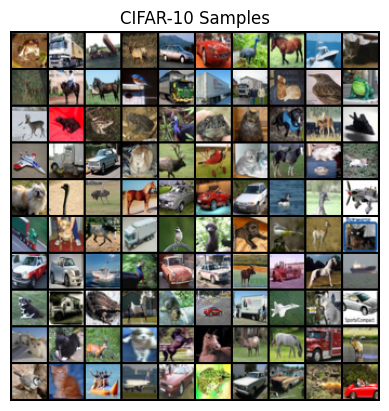

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [3]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [1]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, TensorDataset
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """
    images = images.transpose((0,3,1,2))

    encoded_images = vae.encode(images)
    print(encoded_images.shape)

    decoded_images = vae.decode(encoded_images)

    encoded_images = encoded_images.cpu()
    decoded_images = decoded_images.cpu()

#    autoencoded_images = np.concatenate([images[:50], decoded_images[:50]], axis=0)
    autoencoded_images = torch.concat((torch.tensor(images[:50],dtype=torch.float32).unsqueeze(0), decoded_images[:50].unsqueeze(0)), dim=0)

    autoencoded_images=autoencoded_images.permute((1,0,3,4,2))


    flattened_encoded = encoded_images.reshape(encoded_images.shape[0],-1).numpy()

    scale_factor = np.std(flattened_encoded,axis = 0).mean()
    

    print(scale_factor)
    
    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1000, 4, 8, 8])
0.7378942


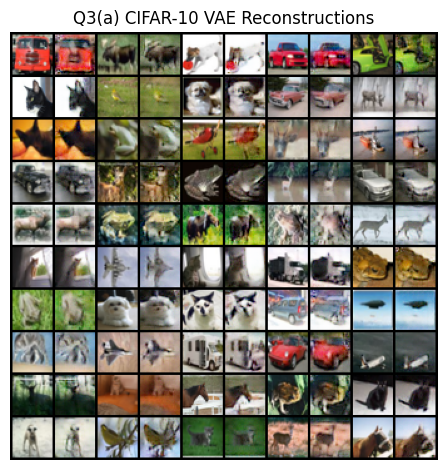

Scale factor: 0.7379


In [2]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

In [ ]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import math
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):   #D,  [H,W]
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed   #(H*W,D)

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


class MLP(nn.Module):
    def __init__(self,hidden_size):
        super(MLP,self).__init__()
        self.hidden_size = hidden_size
        self.net = nn.Sequential(
            nn.Linear(hidden_size,4*hidden_size),
            nn.ReLU(),
            nn.Linear(4*hidden_size,4*hidden_size),
            nn.ReLU(),
            nn.Linear(4*hidden_size,hidden_size)

        )

    def forward(self,x):
        return self.net(x)
    
    


class DiTBlock(nn.Module):
    def __init__(self,hidden_size,num_heads):
        super(DiTBlock,self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.Linear_c = nn.Linear(hidden_size,6*hidden_size)
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.attention = nn.MultiheadAttention(hidden_size,num_heads)
        self.mlp = MLP(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False)


    def forward(self,x,c):

        c= F.silu(c)
        c = self.Linear_c(c)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)

        h = self.norm1(x)
        h = modulate(h,shift_msa,scale_msa)
        x = x + gate_msa.unsqueeze(1) * self.attention(h.transpose(0, 1), h.transpose(0, 1), h.transpose(0, 1))[0].transpose(0, 1)

        h = self.norm2(x)
        h = modulate(h,shift_mlp,scale_mlp)
        x = x+gate_mlp.unsqueeze(1)*self.mlp(h)

        return x



class FinalLayer(nn.Module):
    def __init__(self,hidden_size,patch_size,out_channels):
        super(FinalLayer,self).__init__()
        self.hidden_size = hidden_size
        self.patch_size = patch_size
        self.out_channels = out_channels

        self.Linear_c = nn.Linear(hidden_size, 2*hidden_size)
        self.norm = nn.LayerNorm(hidden_size,elementwise_affine=False)
        self.Linear_x = nn.Linear(hidden_size,patch_size*patch_size*out_channels)

    
    def forward(self,x,c):

        c = F.silu(c)
        c = self.Linear_c(c)

        shift,scale = c.chunk(2,dim=1)

        x = self.norm(x)
        x = modulate(x,shift,scale)
        x = self.Linear_x(x)

        return x

def patchify_flatten(x,patch_size):  # B x C x H x W -> B x (H // P * W // P) x D
    B, C, H, W = x.size()
    P = patch_size
    
    # 确保 H 和 W 都是 P 的倍数
    assert H % P == 0 and W % P == 0, "H and W must be divisible by patch_size."
    
    # 将图像划分为 patches
    x = x.unfold(2, P, P).unfold(3, P, P)  # (B, C, H//P, P, W//P, P)
    x = x.contiguous().view(B, C, -1, P * P)  # (B, C, H//P * W//P, P*P)
    x = x.permute(0, 2, 3, 1)  # (B, H//P * W//P, P*P, C)


    x = x.reshape(B, -1, C * P * P)  # (B, H//P * W//P, D)

    return x

def unpatchify(x, original_height, original_width, patch_size):
    B, num_patches, D = x.size()
    P = patch_size
    C = D // (P * P)  # 计算通道数

    # 计算补丁的数量
    H_patch = original_height // P
    W_patch = original_width // P
    
    # 将补丁形状调整为 (B, H_patch, W_patch, P*P, C)
    x = x.contiguous().view(B, H_patch, W_patch, P * P, C)
    
    # 使用 permute 重排维度
    x = x.permute(0, 4, 1, 2, 3)  # (B, C, H_patch, W_patch, P*P)
    
    # 将补丁展开回原始图像
    x = x.contiguous().view(B, C, H_patch, W_patch, P, P)  # (B, C, H_patch, W_patch, P, P)
    
    # 使用 fold 方法将补丁合并成图像
    x = x.reshape(B, C, H_patch * P, W_patch * P)  # (B, C, H, W)

    return x
    

def timestep_embedding(timesteps, dim, max_period=10000): 

    half = dim // 2
    timesteps = timesteps.squeeze().to(device) #(batch,)
    freqs = torch.exp(-torch.log(torch.tensor(max_period, dtype=torch.float32)) * torch.arange(0, half, dtype=torch.float32) / half).to(device)
    args = torch.tensor(timesteps,dtype = torch.float32)[:, None] * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    if dim % 2:  #if dim is odd
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding  #(batch,dim)

def dropout_classes(class_labels, dropout_prob, null_class):
    # 随机生成掩码
    dropout_mask = torch.rand(class_labels.size()) < dropout_prob
    # 用 null_class 替换被丢弃的标签
    class_labels[dropout_mask] = null_class
    return class_labels


class Dit(nn.Module):
    def __init__(self, input_shape, patch_size, 
                 hidden_size, num_heads, num_layers, 
                 num_classes, cfg_dropout_prob):
        super(Dit,self).__init__()

        self.input_shape = input_shape  # (B,C,H,W)       

        self.patch_size = patch_size
        self.hidden_size= hidden_size
        self.cfg_dropout_prob = cfg_dropout_prob
        self.null_class = num_classes 

        dim_flattened = patch_size*patch_size*input_shape[1]



        self.proj1 = nn.Linear(dim_flattened,hidden_size)      

        self.Block_chan = nn.ModuleList()
    
        for _ in range(num_layers):
            self.Block_chan.append(DiTBlock(hidden_size,num_heads))

        self.embedding = nn.Embedding(num_classes + 1, hidden_size) 
        self.final_layer = FinalLayer(hidden_size, patch_size, input_shape[1])
        
    

    def forward(self,x,y,t,training = True):
        #Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
        
        x = patchify_flatten(x,self.patch_size)  # B x C x H x W -> B x (H // P * W // P) x D
        x = self.proj1(x) #D->hidden_size
        dim_list = list(x.size())
        pos_embed =get_2d_sincos_pos_embed(self.hidden_size, int(math.sqrt(dim_list[1]))) 
        pos_embed = torch.tensor(pos_embed,dtype = torch.float32).to(device)
        x = x+pos_embed[None]

        t = timestep_embedding(t, self.hidden_size, max_period=10000)  #(batch,dim)
        if training:
            y = dropout_classes(y,self.cfg_dropout_prob,self.null_class)  #(batch,)
        
        y = self.embedding(y) 
        c = t+y

        for block in self.Block_chan:
            x = block(x,c)

#        x = self.Block_chan(x,c)
        x = self.final_layer(x,c)  #hidden_size->D
        x = unpatchify(x,self.input_shape[2],self.input_shape[3],self.patch_size)

        return x



**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

Files already downloaded and verified
Files already downloaded and verified
0
1
2
3
4
5
6
7
8
9
Final Test Loss: 0.3886


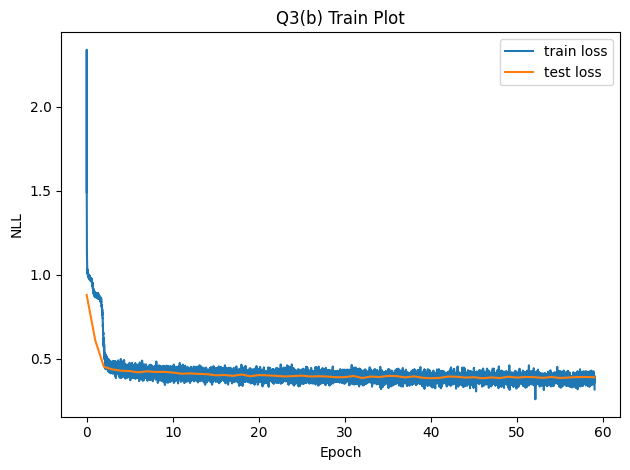

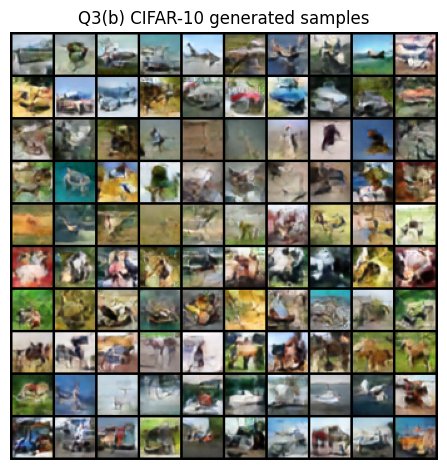

In [5]:
def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """

    '''
#creating dataset
    
# normalized to [-1,1]

    train_data = train_data*2-1
    test_data = test_data*2-1

    train_data = torch.tensor(train_data.transpose((0,3,1,2)),dtype = torch.float32).cpu() #(50000,3,32,32)
    test_data = torch.tensor(test_data.transpose((0,3,1,2)),dtype = torch.float32).cpu()
    train_labels = torch.tensor(train_labels,dtype = torch.int).to(device)  #(num_sample,)
    test_labels = torch.tensor(test_labels,dtype= torch.int).to(device)######

  # encoder
    # 将 VAE 模型移动到 CPU
    vae.to('cpu')

    # 创建数据加载器
    train_data = TensorDataset(train_data)
    test_data = TensorDataset(test_data)
    train_pre_loader = DataLoader(train_data, batch_size=128, shuffle=False)
    test_pre_loader = DataLoader(test_data, batch_size=128, shuffle=False)

    # 逐批处理训练数据
    train_latents = []
    for batch_data in train_pre_loader:
        train_batch = batch_data[0]  # 获取输入数据
        train_latent = vae.encode(train_batch)  # 编码     
        train_latents.append(train_latent)

    # 将所有批次的潜在表示合并
    train_latents = torch.cat(train_latents, dim=0)
    scale_factor_train = torch.std(train_latents,axis = 0).mean().item()
    train_latents = train_latents/scale_factor_train

    # 逐批处理测试数据
    test_latents = []
    for batch_data in test_pre_loader:
        test_batch = batch_data[0] # 获取输入数据
        test_latent = vae.encode(test_batch)  # 编码  
        test_latents.append(test_latent)

    # 将所有批次的潜在表示合并
    test_latents = torch.cat(test_latents, dim=0)
    scale_factor_test = torch.std(test_latents,axis = 0).mean().item()
    test_latents = test_latents / scale_factor_test

    print(scale_factor_train)
    print(scale_factor_test)
    

    # 创建 TensorDataset
    train_dataset = TensorDataset(train_latents, train_labels)
    test_dataset = TensorDataset(test_latents, test_labels)

    torch.save(train_dataset, 'q3_train_dataset.pth')
    torch.save(test_dataset, 'q3_test_dataset.pth') 
    
    '''
    '''
    scale_factor_train =  1.2506710290908813
    scale_factor_test=1.2458577156066895

    train_dataset = torch.load('q3_train_dataset.pth')
    test_dataset = torch.load('q3_test_dataset.pth')


    train_loader = DataLoader(train_dataset,batch_size = 256,shuffle= False)
    test_loader = DataLoader(test_dataset,batch_size=256)

   

    

    train_losses = []
    test_losses = []
    all_samples = np.zeros((10,10,32,32,3))


    batch_size = 256

    input_shape = [batch_size,4,8,8]
    patch_size = 2 
    hidden_size = 512
    num_heads = 8
    num_layers = 12##############
    num_epochs = 60
    num_classes = 10
    cfg_dropout_prob = 0.1


    model = Dit(input_shape, patch_size, 
                 hidden_size, num_heads, num_layers, 
                 num_classes, cfg_dropout_prob)   
    
    model.to(device)

    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr = 1e-4) 

    for epoch in range(num_epochs):
        print("epoch:",epoch)
        model.train()

        for batch in train_loader:
            
            batch_img = batch[0].to(device) #(batch,c,h,w)
            batch_label = batch[1].to(device)##########
            t = torch.rand(batch[0].shape[0], device=device).view(-1,1,1,1)
            noise = torch.randn_like(batch_img)#######randn
            noisy_data = torch.cos(0.5 * torch.pi * t) * batch_img + torch.sin(0.5 * torch.pi * t) * noise  

            optimizer.zero_grad() 

            predicted_noise = model(noisy_data,batch_label,t)
            loss = loss_fn(predicted_noise,noise)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        total_test_loss = 0

        with torch.no_grad():
            for batch in test_loader:


              batch_img = batch[0].to(device) #(batch,c,h,w)
              batch_label = batch[1].to(device)

              t = torch.rand(batch[0].shape[0], device=device).view(-1,1,1,1).to(device)
              noise = torch.randn_like(batch_img)              
              noisy_data = torch.cos(0.5 * torch.pi * t) * batch_img + torch.sin(0.5 * torch.pi * t) * noise .to(device)         

              predicted_noise = model(noisy_data,batch_label,t)

              test_loss = loss_fn(predicted_noise,noise).item()###
              total_test_loss += test_loss
            
        average_test_loss = total_test_loss/len(test_loader)

        test_losses.append(average_test_loss)

    torch.save(model, 'q3_model_.pth')#_______
    with open('q3_train_losses.txt', 'w') as file:
        for item in train_losses:
            file.write("%s\n" % item)

    with open('q3_test_losses.txt', 'w') as file:
        for item in test_losses:
            file.write("%s\n" % item)     

    '''

#    '''

    scale_factor_train =  1.2506710290908813
    scale_factor_test=1.2458577156066895
    model = torch.load('q3_model_.pth')
    train_losses = []
    test_losses = []
    with open('q3_train_losses.txt', 'r') as file:
        for line in file:
            float_number = float(line.strip())
            train_losses.append(float_number)      


    with open('q3_test_losses.txt','r') as file:
        for line in file:
            float_number = float(line.strip())
            test_losses.append(float_number)


    all_samples = np.zeros((10,10,32,32,3))    
    steps = 512

    for idx in range(10):

        batch_size = 10
        class_tag = idx
        print(class_tag)
        class_batch = torch.full((batch_size,), class_tag).to(device)

        

        x = torch.randn(10,4,8,8).to(device)
        t_array =  np.linspace(1 - 1e-4, 1e-4, steps+1)
        # diffuison
        for i in range(steps):

            t_tensor = torch.tensor(t_array[i],dtype = torch.float32).repeat(batch_size)
            t_pre_tensor = torch.tensor(t_array[i+1],dtype = torch.float32).repeat(batch_size)

            t_tensor = t_tensor[:,None,None,None].to(device)
            t_pre_tensor = t_pre_tensor[:,None,None,None].to(device)
            with torch.no_grad():

                predicted_noise = model(x,class_batch,t_tensor,training = False)
                alphat = torch.cos(0.5*np.pi * t_tensor)
                sigmat = torch.sin(0.5*np.pi * t_tensor)
                alphat_1 = torch.cos(0.5*np.pi * (t_pre_tensor))
                sigmat_1 = torch.sin(0.5*np.pi * (t_pre_tensor))
                epsilon = torch.randn_like(x)

                eta = sigmat_1/sigmat*torch.sqrt(1-alphat**2/alphat_1**2)
                clamped_value = torch.clamp(sigmat_1**2-eta**2, min=0) 
                clamped_x_pred = torch.clamp((x-sigmat*predicted_noise)/alphat,min=-3/scale_factor_train,max=3/scale_factor_train)  
                     

                x = alphat_1*clamped_x_pred+torch.sqrt(clamped_value)*predicted_noise + eta*epsilon
            
        
        # anti step3  

        x = x*scale_factor_train

        # anti step2
        vae.to(device)
        x = vae.decode(x)
        #anti step1
        x = x*0.5+0.5

        all_samples[idx] = x.detach().cpu().numpy().transpose((0,2,3,1))


#   '''



            
            
    return train_losses, test_losses, all_samples


q3b_save_results(q3_b)

In [ ]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

(4, 10, 10, 32, 32, 3)


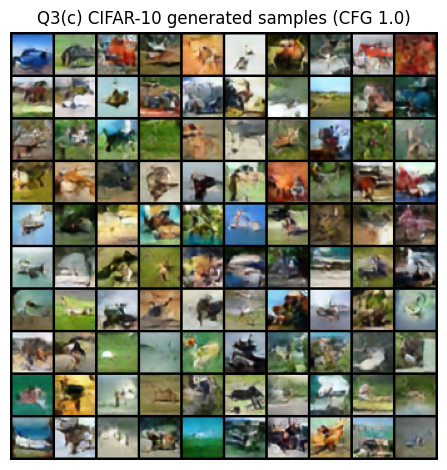

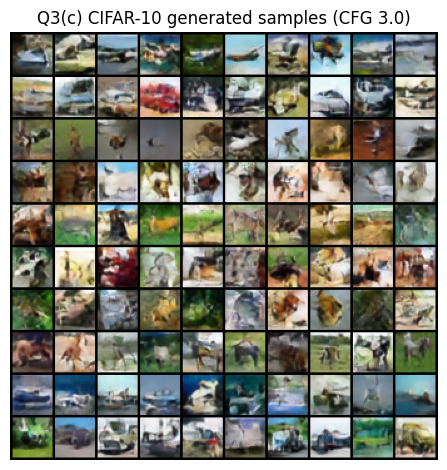

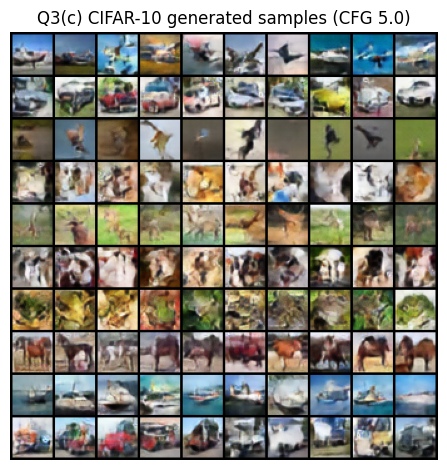

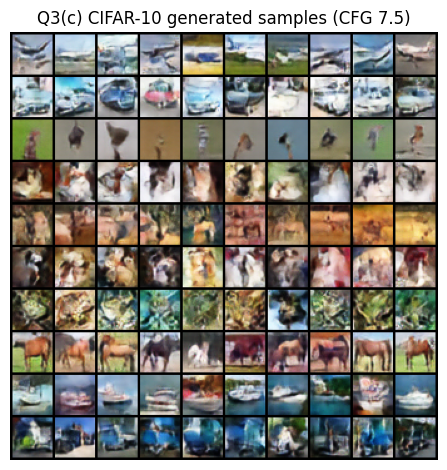

In [7]:
def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """



    all_samples = []
    scale_factor_train =  1.2506710290908813
    scale_factor_test=1.2458577156066895

    model_DiF = torch.load("q3_model_.pth")
                                                  

    w_list = np.array([1,3,5,7.5])
    for w_idx in range(len(w_list)):
        w_sample_list = []
        
        for idx in range(10):
            class_tag = idx
            batch_size = 10
            null_class = 10
            steps = 512
            class_batch = torch.full((batch_size,), class_tag).to(device)
            null_class_batch = torch.full((batch_size,), null_class).to(device)            
            x = torch.randn(10,4,8,8).to(device)
            t_array =  np.linspace(1 - 1e-4, 1e-4, steps+1)


            # diffuison
            for i in range(steps):

                t_tensor = torch.tensor(t_array[i],dtype = torch.float32).repeat(batch_size)
                t_pre_tensor = torch.tensor(t_array[i+1],dtype = torch.float32).repeat(batch_size)

                t_tensor = t_tensor[:,None,None,None].to(device)
                t_pre_tensor = t_pre_tensor[:,None,None,None].to(device)
                with torch.no_grad():

                    predicted_noise_DiF_null_class = model_DiF(x,null_class_batch,t_tensor,training =False)
                    predicted_noise_DiF = model_DiF(x,class_batch,t_tensor,training = False)
                    predicted_noise =predicted_noise_DiF_null_class +w_idx*(predicted_noise_DiF-predicted_noise_DiF_null_class)

                    alphat = torch.cos(0.5*np.pi * t_tensor)
                    sigmat = torch.sin(0.5*np.pi * t_tensor)
                    alphat_1 = torch.cos(0.5*np.pi * (t_pre_tensor))
                    sigmat_1 = torch.sin(0.5*np.pi * (t_pre_tensor))
                    epsilon = torch.randn_like(x)

                    eta = sigmat_1/sigmat*torch.sqrt(1-alphat**2/alphat_1**2)
                    clamped_value = torch.clamp(sigmat_1**2-eta**2, min=0) 
                    clamped_x_pred = torch.clamp((x-sigmat*predicted_noise)/alphat,min=-3/scale_factor_train,max=3/scale_factor_train)           


                    x = alphat_1*clamped_x_pred+torch.sqrt(clamped_value)*predicted_noise + eta*epsilon
                
            
            # anti step3
            x = x*scale_factor_train

            # anti step2
            vae.to(device)
            x = vae.decode(x)
            #anti step1
            x = x*0.5+0.5 

            w_sample_list.append(x.detach().cpu().numpy().transpose((0,2,3,1)))

        all_samples.append(w_sample_list)
        



      
    all_samples = np.array(all_samples)
    print(all_samples.shape)
                              
    return all_samples
q3c_save_results(q3_c)